# inorganic carbon prediction

cross validation settings

In [1]:
validation_method = 'kfoldcv'  
stratified_split = True 

seed_split = 3

k = 10  # number of folds in outer loop
k2 = 10 # number of folds in inner loop

## Imports

In [2]:
import pandas as pd
import logging
from pathlib import Path
import sys
from sklearn.model_selection import StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(Path('.').absolute().parent.resolve().as_posix())
from data_loader import config_loader, data_loader, data_preprocessing
from logging_util.logger import get_logger
from models import estimators
from evaluation import evaluation

2024-12-19 13:30:46,021 - INFO - __init__.py:19 - Loading RandomForestRegressor


In [3]:
config = config_loader.load_config()
logger = get_logger(__name__)
logging.getLogger('shap').setLevel(logging.WARNING)
logging.getLogger('matplotlib').setLevel(logging.WARNING)

features = config.numerical_var + config.categorical_var + config.boolean_var 

In [4]:
outpath = Path().resolve().parent / 'results' / f'target_{config.target}' / 'december2024'
(outpath / validation_method  / 'data').mkdir(parents=True, exist_ok=True)
print("files will be saved in " + str(outpath))

files will be saved in C:\Users\irisj\Desktop\H2020-BAM\results\target_DTIC_mass2\december2024


## Data

In [5]:
data, df_blanks = data_loader.load_data(target=config.target)    
logger.info(f"Using {len(data)} datapoints")

2024-12-19 13:30:50,597 - INFO - 2140973991.py:2 - Using 731 datapoints


In [6]:
data[config.target] = data[config.target].astype('Float64')
data[config.numerical_var] = data[config.numerical_var].astype('Float64')
data[config.boolean_var] = data[config.boolean_var].astype('Int64')

## ML

In [7]:
class outer_model():
    def __init__(self, estimator, dataset, i, data):
        # train_model
        self.estimator = estimator
        self.encoded_dataset = self.estimator.preprocess(dataset)
        self.estimator.fit(
            self.encoded_dataset, validation_method, stratified=stratified_split, df=data
        )
        self.estimator.save(i)
    

class OuterLoop():
    """
    class to store individual models of each fold
    """
    def __init__(self, estimators, data: pd.DataFrame, path: str | Path, k: int):
        self.ix_test = []
        self.data = data
        self.estimators = estimators
        self.path = path
        self.path.mkdir(parents=True, exist_ok=True)

        self.outer_models = {estimator.abbrev: {} for estimator in estimators.values()}
        self.evaluation_metrics = evaluation.Eval_metrics(k, estimators, path)  # _per_min
        
        
    def fold_i(self, dataset, test_ix, i: int):
        self.ix_test += list(test_ix) # test indices of train test split
        self.evaluation_metrics.naive_metrics(dataset, i) # performance of predicting average

        for estimator_name, estimator_cls in self.estimators.items():
                logger.info(estimator_name)

                model = outer_model(estimator_cls(self.path, cv=k2), dataset, i, self.data) 
                self.evaluation_metrics.calculate_metrics(
                    model.estimator, model.encoded_dataset, i, plot_=True, verbose=True
                )
                self.outer_models[model.estimator.abbrev][i] = model


    def plot_prediction(self): 
        for estimator_abbrev in self.outer_models.keys():
            fig = plt.figure(figsize=(4,4))
            for i in range(len(self.outer_models[estimator_abbrev])):
                plt.scatter(self.outer_models[estimator_abbrev][i].encoded_dataset.y_test, 
                            self.outer_models[estimator_abbrev][i].estimator.y_pred,
                            color='k', marker='.')
            plt.plot([min(self.data[config.target]), max(self.data[config.target])], 
                     [min(self.data[config.target]), max(self.data[config.target])], 
                     c='r')
            plt.xlabel(f'measured {config.target}')
            plt.ylabel(f'predicted {config.target}')
            plt.title(estimator_abbrev)
            plt.show()
            plt.close()

In [8]:
def perform_regression_run(seed_split):
    splits = data_preprocessing.cv_split(
            data, validation_method, k, stratified_split, seed_split, nbins=50
    )
    outer_loop = OuterLoop(
                estimators, data, 
                Path(outpath.as_posix()) / validation_method, 
                k if validation_method != 'loocv' else len(data)
    )

    for i, (train_ix, test_ix) in enumerate(splits):
        logger.info(f"Iteration {i+1}/{k}")
                
        dataset = data_preprocessing.train_test_val_split(
            data, outer_loop.path, i, 
            train_i=train_ix, 
            test_i=test_ix, 
            add_validation=(True if validation_method=='traintest' else False),
            random_state=seed_split,
        )
        outer_loop.fold_i(dataset, data.iloc[test_ix].index, i)

    return outer_loop

In [9]:
outer_loop = perform_regression_run(seed_split)

2024-12-19 13:30:51,883 - INFO - 2990128416.py:12 - Iteration 1/10
2024-12-19 13:30:51,999 - INFO - 1063606593.py:32 - RandomForestRegressor
Fitting 10 folds for each of 45 candidates, totalling 450 fits
                   mean  std            0    1    2    3    4    5    6    7  \
MAE  RF       24.103439  NaN    24.103439  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
     naive    29.671388  NaN    29.671388  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
MSE  RF     3678.797665  NaN  3678.797665  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
     naive  2484.948781  NaN  2484.948781  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
RMSE RF       60.653093  NaN    60.653093  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
     naive    49.849261  NaN    49.849261  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
R2   RF       -0.480837  NaN    -0.480837  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
     naive    -0.000274  NaN    -0.000274  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

              8    9  
MAE  RF     NaN  NaN  
     naive  NaN  NaN  
MSE  R

## Results

### 1. Plot prediction

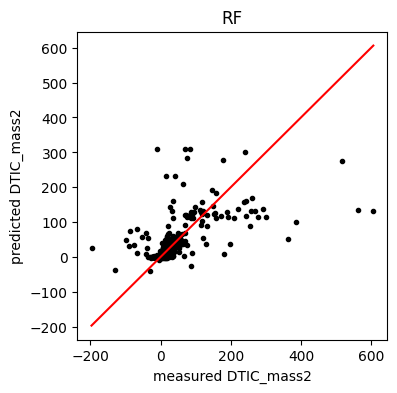

In [10]:
outer_loop.plot_prediction()

### 2. Performance

#### a. on test set

In [11]:
outer_loop.evaluation_metrics.metrics['test'] 

mean          std            0            1            2  \
MAE  RF       18.030028     5.927015    24.103439    16.666477    13.473629   
     naive    29.681096     4.552504    29.671388    27.009029    29.952966   
MSE  RF     2293.420876  1816.158423  3678.797665  1588.775246   782.319224   
     naive  3745.079992  2585.789597  2484.948781  2973.741469  2845.252646   
RMSE RF       44.959658    17.386138    60.653093    39.859444     27.96997   
     naive    58.918697    17.437735    49.849261    54.532022     53.34091   
R2   RF        0.384779     0.340503    -0.480837      0.46538     0.724656   
     naive    -0.004887     0.006220    -0.000274    -0.000658    -0.001412   

                      3             4            5            6            7  \
MAE  RF       13.180469     31.300118    12.714896    16.267108    14.175604   
     naive    26.656442     41.604353    26.080368    28.208699    26.693612   
MSE  RF      707.500209   6513.501605   916.485093  1249.704975  1484.612187   
     naive  2615.833338  10631.500794  1971.507536  2600.860954  2142.886194   
RMSE RF       26.598876     80.706267    30.273505    35.351167    38.530666   
     naive    51.145218    103.109169    44.401661    50.998637    46.291319   
R2   RF        0.729353       0.37687     0.534185     0.518569     0.296697   
     naive    -0.000659     -0.017089    -0.002043    -0.001945    -0.015147   

                      8           9  
MAE  RF        21.21543   17.203111  
     naive    31.630523   29.303581  
MSE  RF     3064.132719  2948.37984  
     naive  4470.941523  4713.32668  
RMSE RF       55.354609   54.298986  
     naive    66.865099   68.653672  
R2   RF        0.312736    0.370181  
     naive    -0.002802   -0.006839

#### b. on training set

In [12]:
outer_loop.evaluation_metrics.metrics['train']

mean         std            0            1            2  \
MAE  RF       13.018958    0.557409    12.028099    13.332532    12.948701   
     naive    29.582415    0.796482    29.516791    29.927218    29.414927   
MSE  RF      906.807375  117.534398   691.235108   966.083256   916.320077   
     naive  3701.245044  273.746454  3835.911744  3775.602095  3793.092356   
RMSE RF       30.053808    1.993314     26.29135     31.08188    30.270779   
     naive    60.797345    2.339963    61.934738    61.445928    61.588086   
R2   RF        0.754414    0.030548     0.819799     0.744125     0.758424   
     naive     0.000000    0.000000          0.0          0.0          0.0   

                      3            4            5            6            7  \
MAE  RF       13.790948    12.581539    13.412061     13.35938    13.291495   
     naive    29.958255     27.53868    30.097707    29.941885    30.267048   
MSE  RF     1079.942156   810.586368   1000.72776   966.607295   915.665449   
     naive  3812.308398  2980.386858  3892.911081  3849.695042  3874.207638   
RMSE RF       32.862473    28.470799    31.634281    31.090309    30.259964   
     naive    61.743894    54.592919    62.393197    62.045911    62.243133   
R2   RF        0.716722     0.728026     0.742936     0.748913     0.763651   
     naive          0.0          0.0          0.0          0.0          0.0   

                      8           9  
MAE  RF         12.2733   13.171528  
     naive    29.146872   30.014769  
MSE  RF      764.937722  955.968556  
     naive  3619.582558  3578.75267  
RMSE RF       27.657508   30.918741  
     naive    60.162967   59.822677  
R2   RF        0.788667    0.732877  
     naive          0.0         0.0